# Imports

In [1]:
import re
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# Load data

In [ ]:
df = (
    pd.read_json("../artifacts/data/raw/datasetN=30.jsonl", lines=True)
    .set_index(["question_id", "sample_id"])
    .sort_index()
)
df.head()

question  \
question_id sample_id                                                      
0           0          Natalia sold clips to 48 of her friends in Apr...   
            1          Natalia sold clips to 48 of her friends in Apr...   
            2          Natalia sold clips to 48 of her friends in Apr...   
            3          Natalia sold clips to 48 of her friends in Apr...   
            4          Natalia sold clips to 48 of her friends in Apr...   

                                                        gold_answer_text  \
question_id sample_id                                                      
0           0          Natalia sold 48/2 = <<48/2=24>>24 clips in May...   
            1          Natalia sold 48/2 = <<48/2=24>>24 clips in May...   
            2          Natalia sold 48/2 = <<48/2=24>>24 clips in May...   
            3          Natalia sold 48/2 = <<48/2=24>>24 clips in May...   
            4          Natalia sold 48/2 = <<48/2=24>>24 clips in May...   

                       gold_answer_number  \
question_id sample_id                       
0           0                          72   
            1                          72   
            2                          72   
            3                          72   
            4                          72   

                                                     teacher_answer_text  \
question_id sample_id                                                      
0           0          Reasoning:\n- Clips sold in April: 48\n- Clips...   
            1          - Clips in April: 48\n- Clips in May: 48 ÷ 2 =...   
            2          Reasoning:\n- Clips sold in April: 48\n- Clips...   
            3          Reasoning:\n- April sales: 48\n- May sales: 48...   
            4          Reasoning:\n- Clips sold in April: 48\n- Clips...   

                       teacher_answer_number  is_correct finish_reason  \
question_id sample_id                                                    
0           0                             72        True          stop   
            1                             72        True          stop   
            2                             72        True          stop   
            3                             72        True          stop   
            4                             72        True          stop   

                                                                   usage  \
question_id sample_id                                                      
0           0          {'prompt_tokens': 492, 'completion_tokens': 11...   
            1          {'prompt_tokens': 492, 'completion_tokens': 92...   
            2          {'prompt_tokens': 492, 'completion_tokens': 14...   
            3          {'prompt_tokens': 492, 'completion_tokens': 15...   
            4          {'prompt_tokens': 492, 'completion_tokens': 14...   

                       latency_ms                                  model  \
question_id sample_id                                                      
0           0                3842  deepseek/deepseek-r1-distill-qwen-32b   
            1                3064  deepseek/deepseek-r1-distill-qwen-32b   
            2                3401  deepseek/deepseek-r1-distill-qwen-32b   
            3                3651  deepseek/deepseek-r1-distill-qwen-32b   
            4                3535  deepseek/deepseek-r1-distill-qwen-32b   

                                                request_id  
question_id sample_id                                       
0           0          gen-1758377575-oMv82kc9HfBY8pUPbFYs  
            1          gen-1758377579-EqblKG6QXW2nK8zqjlZZ  
            2          gen-1758377582-CUs4tuG1WgP5Pw8IRYmY  
            3          gen-1758377586-akeYwooKqWXHaULQM0lK  
            4          gen-1758377590-sAz1pvSg3wVeEYJ7J02i

In [5]:
usage_df = df["usage"].apply(
    lambda x: pd.Series(
        {
            "prompt_tokens": x["prompt_tokens"],
            "completion_tokens": x["completion_tokens"],
            "total_tokens": x["total_tokens"],
        }
    )
)
df = pd.concat([df.drop(columns="usage"), usage_df], axis=1)

In [6]:
df["teacher_answer_length"] = df["teacher_answer_text"].str.len()

# Analysis

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 300 entries, (np.int64(0), np.int64(0)) to (np.int64(9), np.int64(29))
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   question               300 non-null    object
 1   gold_answer_text       300 non-null    object
 2   gold_answer_number     300 non-null    int64 
 3   teacher_answer_text    300 non-null    object
 4   teacher_answer_number  300 non-null    int64 
 5   is_correct             300 non-null    bool  
 6   finish_reason          300 non-null    object
 7   latency_ms             300 non-null    int64 
 8   model                  300 non-null    object
 9   request_id             300 non-null    object
 10  prompt_tokens          300 non-null    int64 
 11  completion_tokens      300 non-null    int64 
 12  total_tokens           300 non-null    int64 
 13  teacher_answer_length  300 non-null    int64 
dtypes: bool(1), int64(7), obj

In [22]:
df.describe()

,gold_answer_number,teacher_answer_number,latency_ms,prompt_tokens,completion_tokens,total_tokens,teacher_answer_length,reasoning_step_count,cost_usd
count,250.000000,250.00000,250.00000,250.000000,250.000000,250.000000,250.000000,247.000000,250.000000
mean,9284.520000,9293.25520,6012.62800,517.280000,246.868000,764.148000,186.308000,5.287449,0.000206
std,62804.554409,62860.66767,2081.21141,19.320838,102.421929,109.188969,63.496301,1.565106,0.000029
min,5.000000,4.80000,2268.00000,480.000000,74.000000,584.000000,66.000000,3.000000,0.000158
25%,15.000000,15.00000,4705.75000,507.000000,174.500000,687.750000,131.250000,4.000000,0.000186
50%,42.500000,43.00000,5596.00000,515.500000,225.500000,740.000000,184.000000,5.000000,0.000200
75%,400.000000,400.00000,6971.25000,526.000000,287.750000,813.750000,222.000000,6.000000,0.000220
max,448000.000000,450000.00000,13821.00000,569.000000,620.000000,1144.000000,388.000000,11.000000,0.000309


In [8]:
df["model"].unique()

array(['deepseek/deepseek-r1-distill-qwen-32b'], dtype=object)

In [9]:
df["finish_reason"].unique()

array(['stop'], dtype=object)

In [10]:
len(df["question"].unique())

10

In [11]:
len(df["teacher_answer_text"].unique())

255

In [12]:
df["is_correct"].value_counts()

is_correct
True     292
False      8
Name: count, dtype: int64

In [13]:
(df["gold_answer_number"] == df["teacher_answer_number"]).value_counts()

True     292
False      8
Name: count, dtype: int64

In [14]:
print(
    f"Accuracy: {(df['gold_answer_number'] == df['teacher_answer_number']).mean() * 100:.2f}%"
)

Accuracy: 97.33%


In [15]:
df[["completion_tokens", "prompt_tokens"]].mean()

completion_tokens    225.673333
prompt_tokens        515.200000
dtype: float64

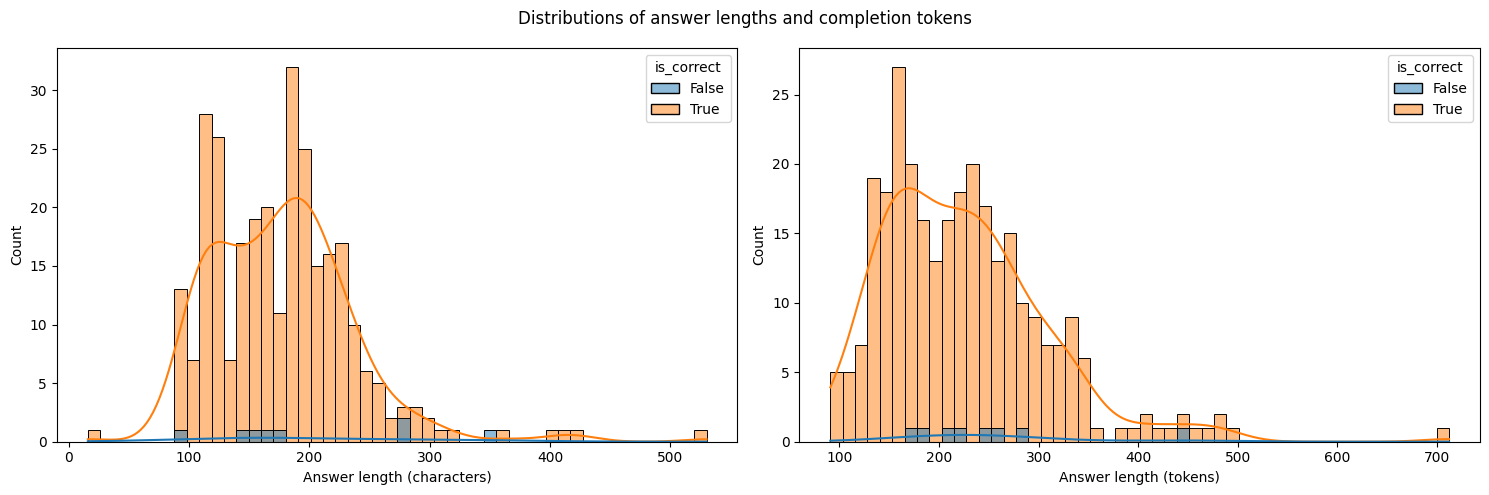

In [16]:
fig, axs = plt.subplots(1, 2, figsize=(15, 5))
fig.suptitle("Distributions of answer lengths and completion tokens")

sns.histplot(
    data=df, x="teacher_answer_length", bins=50, hue="is_correct", kde=True, ax=axs[0]
)
axs[0].set_xlabel("Answer length (characters)")

sns.histplot(
    data=df, x="completion_tokens", bins=50, hue="is_correct", kde=True, ax=axs[1]
)
axs[1].set_xlabel("Answer length (tokens)")
fig.tight_layout()

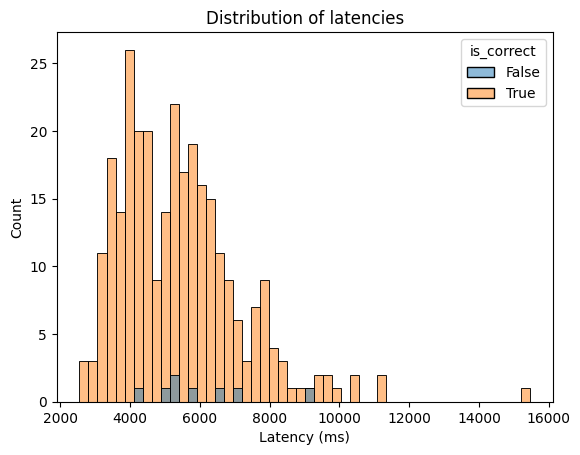

In [17]:
sns.histplot(data=df, x="latency_ms", hue="is_correct", bins=50)
plt.title("Distribution of latencies")
plt.xlabel("Latency (ms)")
plt.show()

## Reasoning analysis

In [18]:
df["reasoning_text"] = (
    df["teacher_answer_text"]
    .str.extract(
        r"Reasoning:\s*(.*?)\s*Final\sAnswer",
        flags=re.IGNORECASE | re.DOTALL,
        expand=False,
    )
    .str.strip()
)
df["reasoning_step_count"] = (
    df["reasoning_text"].str.count(r"^\s*[-–—]\s", flags=re.MULTILINE) + 1
)

<Axes: xlabel='reasoning_step_count', ylabel='Count'>

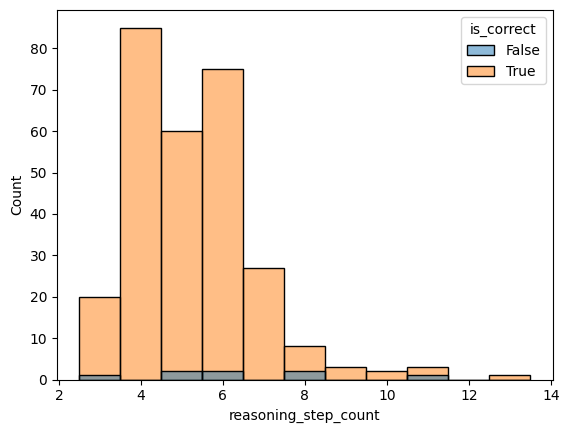

In [19]:
sns.histplot(data=df, x="reasoning_step_count", hue="is_correct", discrete=True)

## Error analysis

In [20]:
pd.set_option("display.max_colwidth", None)

mistakes = df.loc[
    ~df["is_correct"], ["question", "teacher_answer_text", "gold_answer_text"]
].copy()

for (row_idx, sample_id), row in mistakes.iterrows():
    print(f"Row {row_idx}, Sample {sample_id}")
    print("-" * 80)
    print("Question:\n", row["question"])
    print("\nTeacher answer:\n", row["teacher_answer_text"])
    print("\nGold answer:\n", row["gold_answer_text"])
    print("\n" + "=" * 80 + "\n")

Row 4, Sample 0
--------------------------------------------------------------------------------
Question:
 James writes a 3-page letter to 2 different friends twice a week.  How many pages does he write a year?

Teacher answer:
 Reasoning:
- Weekly pages: 3 pages/week * 2 = 6
- Annual pages: 6 * 52 = 312
Final Answer: 312

Gold answer:
 He writes each friend 3*2=<<3*2=6>>6 pages a week
So he writes 6*2=<<6*2=12>>12 pages every week
That means he writes 12*52=<<12*52=624>>624 pages a year
#### 624


Row 4, Sample 8
--------------------------------------------------------------------------------
Question:
 James writes a 3-page letter to 2 different friends twice a week.  How many pages does he write a year?

Teacher answer:
 Reasoning:
- Letters per week: 2
- Pages per letter: 3
- Weekly pages: 2 × 3 = 6
- Weeks per year: 52
- Annual pages: 6 × 52 = 312

Final Answer: 312

Gold answer:
 He writes each friend 3*2=<<3*2=6>>6 pages a week
So he writes 6*2=<<6*2=12>>12 pages every week
Tha

In [21]:
df.loc[9, ["question", "teacher_answer_text", "gold_answer_text"]]

,question,teacher_answer_text,gold_answer_text
sample_id,,,
0,"Tina makes $18.00 an hour. If she works more than 8 hours per shift, she is eligible for overtime, which is paid by your hourly wage + 1/2 your hourly wage. If she works 10 hours every day for 5 days, how much money does she make?",Reasoning:\n- Regular hourly wage: $18.00\n- Overtime wage: 18 + (18 × 0.5) = 27\n- Regular hours: 8\n- Overtime hours: 10 - 8 = 2\n- Daily earnings: (8 × 18) + (2 × 27)\n- Total earnings: 5 × [(8 × 18) + (2 × 27)] = 5 × [144 + 54] = 5 × 198 = 990\nFinal Answer: 990,"She works 8 hours a day for $18 per hour so she makes 8*18 = $<<8*18=144.00>>144.00 per 8-hour shift\nShe works 10 hours a day and anything over 8 hours is eligible for overtime, so she gets 10-8 = <<10-8=2>>2 hours of overtime\nOvertime is calculated as time and a half so and she makes $18/hour so her overtime pay is 18*.5 = $<<18*.5=9.00>>9.00\nHer overtime pay is 18+9 = $<<18+9=27.00>>27.00\nHer base pay is $144.00 per 8-hour shift and she works 5 days and makes 5 * $144 = $<<144*5=720.00>>720.00\nHer overtime pay is $27.00 per hour and she works 2 hours of overtime per day and makes 27*2 = $<<27*2=54.00>>54.00 in overtime pay\n2 hours of overtime pay for 5 days means she makes 54*5 = $270.00\nIn 5 days her base pay is $720.00 and she makes $270.00 in overtime pay so she makes $720 + $270 = $<<720+270=990.00>>990.00\n#### 990"
1,"Tina makes $18.00 an hour. If she works more than 8 hours per shift, she is eligible for overtime, which is paid by your hourly wage + 1/2 your hourly wage. If she works 10 hours every day for 5 days, how much money does she make?",Reasoning:\n- Regular Pay: 8 hours × $18.00/hour = $144.00\n- Overtime Pay Rate: $18.00 + (1/2 × $18.00) = $27.00/hour\n- Overtime Pay: 2 hours × $27.00 = $54.00\n- Total Daily Pay: $144.00 + $54.00 = $198.00\n- Total Weekly Pay: 5 days × $198.00/day = $990.00\nFinal Answer: 990,"She works 8 hours a day for $18 per hour so she makes 8*18 = $<<8*18=144.00>>144.00 per 8-hour shift\nShe works 10 hours a day and anything over 8 hours is eligible for overtime, so she gets 10-8 = <<10-8=2>>2 hours of overtime\nOvertime is calculated as time and a half so and she makes $18/hour so her overtime pay is 18*.5 = $<<18*.5=9.00>>9.00\nHer overtime pay is 18+9 = $<<18+9=27.00>>27.00\nHer base pay is $144.00 per 8-hour shift and she works 5 days and makes 5 * $144 = $<<144*5=720.00>>720.00\nHer overtime pay is $27.00 per hour and she works 2 hours of overtime per day and makes 27*2 = $<<27*2=54.00>>54.00 in overtime pay\n2 hours of overtime pay for 5 days means she makes 54*5 = $270.00\nIn 5 days her base pay is $720.00 and she makes $270.00 in overtime pay so she makes $720 + $270 = $<<720+270=990.00>>990.00\n#### 990"
2,"Tina makes $18.00 an hour. If she works more than 8 hours per shift, she is eligible for overtime, which is paid by your hourly wage + 1/2 your hourly wage. If she works 10 hours every day for 5 days, how much money does she make?",Reasoning:\n- Regular pay: 8 × $18 = $144 per day\n- Overtime rate: $18 + (1/2 × $18) = $27 per hour\n- Overtime pay: 2 × $27 = $54 per day\n- Total daily earnings: $144 + $54 = $198\n- Total earnings: 5 × $198 = $990\n\nFinal Answer: 990,"She works 8 hours a day for $18 per hour so she makes 8*18 = $<<8*18=144.00>>144.00 per 8-hour shift\nShe works 10 hours a day and anything over 8 hours is eligible for overtime, so she gets 10-8 = <<10-8=2>>2 hours of overtime\nOvertime is calculated as time and a half so and she makes $18/hour so her overtime pay is 18*.5 = $<<18*.5=9.00>>9.00\nHer overtime pay is 18+9 = $<<18+9=27.00>>27.00\nHer base pay is $144.00 per 8-hour shift and she works 5 days and makes 5 * $144 = $<<144*5=720.00>>720.00\nHer overtime pay is $27.00 per hour and she works 2 hours of overtime per day and makes 27*2 = $<<27*2=54.00>>54.00 in overtime pay\n2 hours of overtime pay for 5 days means she makes 54*5 = $270.00\nIn 5 days her base pay is $720.00 and she makes $270.00 

## Cost analysis

In [22]:
COST_PER_M_INPUT_TOKENS = 0.27
COST_PER_M_OUTPUT_TOKENS = 0.27
df["cost_usd"] = (
    df["prompt_tokens"] * COST_PER_M_INPUT_TOKENS / 1_000_000
    + df["completion_tokens"] * COST_PER_M_OUTPUT_TOKENS / 1_000_000
)
print(
    f"Total cost: ${df['cost_usd'].sum():.5f}, Average cost: ${df['cost_usd'].mean():.5f}, Median cost: ${df['cost_usd'].median():.5f}, Stddev: ${df['cost_usd'].std():.6f}"
)

Total cost: $0.06001, Average cost: $0.00020, Median cost: $0.00020, Stddev: $0.000025


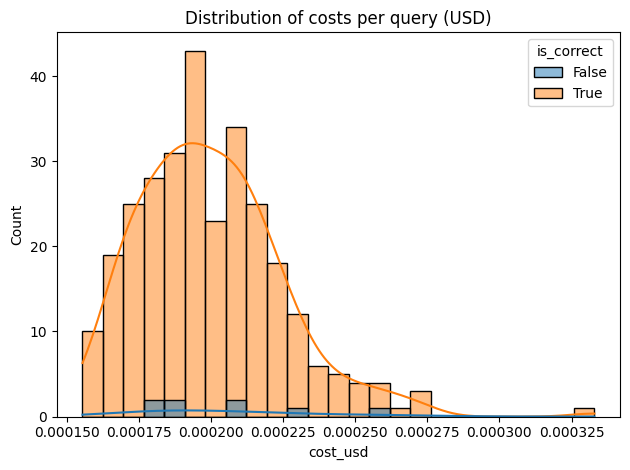

In [23]:
sns.histplot(data=df, x="cost_usd", bins=25, kde=True, hue="is_correct")
plt.title("Distribution of costs per query (USD)")
plt.tight_layout()